In [2]:
import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

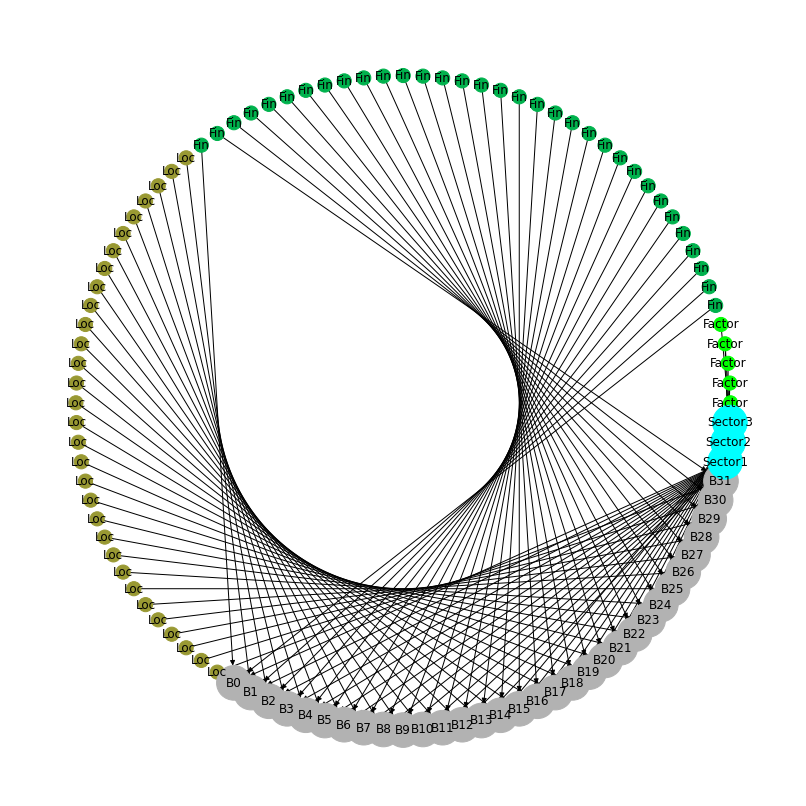

In [3]:
def build_borrower_sector_graph():

    
    b_s_src = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31])
    b_s_dst = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2])
    
    
    data_dict = {
    ('sector', 'belongs to', 'borrower'): (T.tensor(b_s_dst), T.tensor(b_s_src)),
    ('Fin', 'depends', 'borrower'): (T.arange(0,32), T.arange(0,32)),
    ('Loc', 'are', 'borrower'): (T.arange(0,32), T.arange(0,32)),
    ('Factor', 'effect', 'sector'): (T.tensor([0,1,1,2,3,3,4]), T.tensor([0,0,1,1,1,2,2]))
    }

    return dgl.heterograph(data_dict)

G = build_borrower_sector_graph()
G_homo = dgl.to_homogeneous(G)
nx_G = G_homo.to_networkx()
pos = nx.circular_layout(nx_G)

codes = []
for i in range(G_homo.num_nodes()):
    if i <5:
        codes.append(3)
    elif i >=5 and i<=37:
        codes.append(6)
    elif i>37 and i<69:
        codes.append(5)
    elif i>=69 and i<101:
        codes.append(0)
    else:
        codes.append(2)
        
colors = T.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])

plt.figure(figsize=(11, 11))
node_sizes = []
for i in range(G_homo.num_nodes()):
    if i <5:
        node_sizes.append(200)
    elif i >=5 and i<=37:
        node_sizes.append(200)
    elif i>37 and i<69:
        node_sizes.append(200)
    elif i>=69 and i<101:
        node_sizes.append(1200)
    else:
        node_sizes.append(1200)
        
labels = {}
for i in range(G_homo.num_nodes()):
    if i <5:
        labels.update({i : "Factor"})
    elif i >=5 and i<=37:
        labels.update({i : "Fin"})
    elif i>37 and i<69:
        labels.update({i : "Loc"})
    elif i>=69 and i<101:
        labels.update({i : "B"+str(i-69)})
    else:
        labels.update({i : "Sector"+str(i-100)})

nx.draw(nx_G, pos, node_size = node_sizes, with_labels=False, node_color=colors[codes])
D = nx.draw_networkx_labels(nx_G, pos,labels)

In [4]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(in_feats, hid_feats) for rel in rel_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(hid_feats, out_feats)for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        #print("layer 1 : ",h)
        #h = {k: F.relu(v) for k, v in h.items()}
        #print("Relu : ",h)
        #h = self.conv2(graph, h)
        #print("layer 2 : ",h)
        return h
   


In [ ]:
G.nodes['borrower'].data['f'] = T.tensor([[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
                                          [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
                                          [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
                                          [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
                                          [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
                                          [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
                                          [1, 0, 0, 0, 1],[1, 0, 0, 0, 1]])

G.nodes['Fin'].data['f'] = T.tensor([[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],
                                [1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],
                                [1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 0, 1, 10],[1, 0, 1, 0, 10],
                                [1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 0, 1, 10],[1, 0, 1, 0, 10],
                                [1, 0, 1, 0, 100],[1, 0, 1, 0, 101],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],
                                [1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],
                                [1, 0, 1, 0, 100],[1, 0, 1, 0, 105]])
#G.nodes['Fin'].data['f'] = T.normal(0, 1, size=(32, 5))

G.nodes['Loc'].data['f'] = T.tensor([[0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
                                     [0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
                                     [0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
                                     [0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
                                     [2, 0, 7, 4, 0],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],
                                     [2, 0, 7, 4, 0],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],
                                     [2, 0, 7, 4, 0],[2, 0, 7, 4, 2]])

G.nodes['Factor'].data['f'] = T.tensor([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[0, 0, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]])

G.nodes['sector'].data['f'] = T.tensor([[1, 1, 100, 1, 1],[100, 1, 1, 1, 1],[1, 1, 1, 1, 100]])

In [ ]:
borrower_feats = G.nodes['borrower'].data['f']
sector_feats = G.nodes['sector'].data['f']
fin_feats = G.nodes['Fin'].data['f']
loc_feats = G.nodes['Loc'].data['f']
factor_feats = G.nodes['Factor'].data['f']

b_labels = T.tensor([0,1])
labeled_borrowers = T.tensor([0,31])

node_features = {'borrower':borrower_feats,'sector':sector_feats,'Fin':fin_feats,'Loc':loc_feats,'Factor':factor_feats}

opt = T.optim.Adam(model.parameters(),lr=0.01)

for epoch in range(1):
    
    model.train()
    logits = model(G, node_features)
    borrower_embeddings = logits['borrower']

    loss = F.cross_entropy(logits['borrower'][labeled_borrowers], b_labels)
    #print("Loss: ",loss," Iteration: ",epoch)
    
    opt.zero_grad()
    loss.backward()
    opt.step()


print(logits)
b_colors = T.tensor([[.5,0,.8],[1,0,0],[.7,0,.4],[1,1,0]])
o_colors = T.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])

X = logits['borrower'].detach().numpy()
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

prediction = T.tensor(kmeans.predict(X)).long()

colors = T.cat((o_colors[codes[:69]],b_colors[prediction]))

plt.figure(figsize=(11, 11))
nx.draw(nx_G, pos, node_size = node_sizes, with_labels=False, node_color=T.cat((colors,o_colors[[2,2,2]])))
D = nx.draw_networkx_labels(nx_G, pos,labels)

In [ ]:
# model = RGCN(5, 5, 2, G.etypes)

# G.nodes['borrower'].data['f'] = T.tensor([[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
#                                           [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
#                                           [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
#                                           [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
#                                           [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
#                                           [0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],[0, 0, 1, 1, 1],
#                                           [1, 0, 0, 0, 1],[1, 0, 0, 0, 1]])

# G.nodes['Fin'].data['f'] = T.tensor([[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],
#                                 [1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],
#                                 [1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 0, 1, 10],[1, 0, 1, 0, 10],
#                                 [1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 1, 0, 10],[1, 0, 0, 1, 10],[1, 0, 1, 0, 10],
#                                 [1, 0, 1, 0, 100],[1, 0, 1, 0, 101],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],
#                                 [1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],[1, 0, 1, 0, 100],
#                                 [1, 0, 1, 0, 100],[1, 0, 1, 0, 105]])
# #G.nodes['Fin'].data['f'] = T.normal(0, 1, size=(32, 5))

# G.nodes['Loc'].data['f'] = T.tensor([[0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
#                                      [0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
#                                      [0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
#                                      [0,8, 8, 1, 0],[0, 8, 8, 1, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],[0, 8, 8, 1, 2],
#                                      [2, 0, 7, 4, 0],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],
#                                      [2, 0, 7, 4, 0],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],[2, 0, 7, 4, 0],[2, 0, 7, 4, 2],
#                                      [2, 0, 7, 4, 0],[2, 0, 7, 4, 2]])

# G.nodes['Factor'].data['f'] = T.tensor([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[0, 0, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]])

# G.nodes['sector'].data['f'] = T.tensor([[1, 1, 100, 1, 1],[100, 1, 1, 1, 1],[1, 1, 1, 1, 100]])

# model = RGCN(5, 5, 2, G.etypes)

# G.nodes['borrower'].data['f'] = T.normal(1, 1, size=(32, 5))
# G.nodes['Fin'].data['f'] = T.normal(1, 1, size=(32, 5))
# G.nodes['Loc'].data['f'] = T.normal(1, 1, size=(32, 5))
# G.nodes['Factor'].data['f'] = T.normal(1, 1, size=(5, 5))
# G.nodes['sector'].data['f'] = T.normal(1, 1, size=(3, 5))

# class RGCN(nn.Module):
#     def __init__(self, in_feats, hid_feats, out_feats, rel_names):
#         super().__init__()

#         self.conv1 = dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(in_feats, hid_feats) for rel in rel_names}, aggregate='sum')
#         self.conv2 = dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(hid_feats, out_feats)for rel in rel_names}, aggregate='sum')

#     def forward(self, graph, inputs):
#         h = self.conv1(graph, inputs)
#         #print("layer 1 : ",h)
#         h = {k: F.relu(v) for k, v in h.items()}
#         #print("Relu : ",h)
#         h = self.conv2(graph, h)
#         #print("layer 2 : ",h)
#         return h
   
